In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import feather
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
FILE_APP_TRAIN = "F:/kaggle/HomeCredit/input/application_train.csv"
FILE_APP_TEST = "F:/kaggle/HomeCredit/input/application_test.csv"
FILE_bureau = "F:/kaggle/HomeCredit/input/bureau.csv"
FILE_bureau_balance = "F:/kaggle/HomeCredit/input/bureau_balance.csv"
FILE_previous_application = "F:/kaggle/HomeCredit/input/previous_application.csv"
FILE_POS_CASH_balance = "F:/kaggle/HomeCredit/input/POS_CASH_balance.csv"
FILE_installments_payments = "F:/kaggle/HomeCredit/input/installments_payments.csv"
FILE_credit_card_balance = "F:/kaggle/HomeCredit/input/credit_card_balance.csv"

FILE_FEAT = "F:/kaggle/HomeCredit/feat/0827.fth"
FILE_FEAT_LIST = "F:/kaggle/HomeCredit/feat/feat_list_0827.csv"

In [3]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [4]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df_train = pd.read_csv(FILE_APP_TRAIN, nrows= num_rows)
    df_test = pd.read_csv(FILE_APP_TEST, nrows= num_rows)
    df = pd.concat([df_train, df_test], axis = 0, ignore_index = True)
    del df_train, df_test
    gc.collect()
    
    # Remove some rows with values not present in test set
    df.drop(df[df['CODE_GENDER'] == 'XNA'].index, inplace = True)
    df.drop(df[df['NAME_INCOME_TYPE'] == 'Maternity leave'].index, inplace = True)
    df.drop(df[df['NAME_FAMILY_STATUS'] == 'Unknown'].index, inplace = True)
    
    # Remove some empty features
    df.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
            'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 
            'FLAG_DOCUMENT_21'], axis = 1, inplace = True)
    
    # Replace some outliers
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
    df.loc[df['OWN_CAR_AGE'] > 80, 'OWN_CAR_AGE'] = np.nan
    df.loc[df['REGION_RATING_CLIENT_W_CITY'] < 0, 'REGION_RATING_CLIENT_W_CITY'] = np.nan
    df.loc[df['AMT_INCOME_TOTAL'] > 1e8, 'AMT_INCOME_TOTAL'] = np.nan
    df.loc[df['AMT_REQ_CREDIT_BUREAU_QRT'] > 10, 'AMT_REQ_CREDIT_BUREAU_QRT'] = np.nan
    df.loc[df['OBS_30_CNT_SOCIAL_CIRCLE'] > 40, 'OBS_30_CNT_SOCIAL_CIRCLE'] = np.nan
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], _ = pd.factorize(df[bin_feature])
        
    # Categorical features with One-Hot encode
    df, _ = one_hot_encoder(df, nan_as_category)
    
    # Some new features
    df['app missing'] = df.isnull().sum(axis = 1).values
    
    df['app EXT_SOURCE mean'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    df['app EXT_SOURCE min'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].min(axis = 1)
    df['app EXT_SOURCE max'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].max(axis = 1)
    df['app EXT_SOURCE count'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].count(axis = 1)
    df['app EXT_SOURCE std'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis = 1)
    df['app EXT_SOURCE prod'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['app EXT_SOURCE norm'] = (df['EXT_SOURCE_1']**2 + df['EXT_SOURCE_2']**2 + df['EXT_SOURCE_3']**2) / df['app EXT_SOURCE count']
    df['app EXT_SOURCE_1 * EXT_SOURCE_2'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2']
    df['app EXT_SOURCE_1 * EXT_SOURCE_3'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_3']
    df['app EXT_SOURCE_2 * EXT_SOURCE_3'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['app EXT_SOURCE_1 / EXT_SOURCE_2'] = df['EXT_SOURCE_1'] / df['EXT_SOURCE_2']
    df['app EXT_SOURCE_1 / EXT_SOURCE_3'] = df['EXT_SOURCE_1'] / df['EXT_SOURCE_3']
    df['app EXT_SOURCE_2 / EXT_SOURCE_3'] = df['EXT_SOURCE_2'] / df['EXT_SOURCE_3']
    df['app EXT_SOURCE_1 * DAYS_EMPLOYED'] = df['EXT_SOURCE_1'] * (1+df['DAYS_EMPLOYED'])
    df['app EXT_SOURCE_2 * DAYS_EMPLOYED'] = df['EXT_SOURCE_2'] * (1+df['DAYS_EMPLOYED'])
    df['app EXT_SOURCE_3 * DAYS_EMPLOYED'] = df['EXT_SOURCE_3'] * (1+df['DAYS_EMPLOYED'])
    df['app EXT_SOURCE mean * DAYS_EMPLOYED'] = df['app EXT_SOURCE mean'] * (1+df['DAYS_EMPLOYED'])
    df['app EXT_SOURCE norm * DAYS_EMPLOYED'] = df['app EXT_SOURCE norm'] * (1+df['DAYS_EMPLOYED'])
    
    df['app EXT_SOURCE mean / DAYS_BIRTH'] = df['app EXT_SOURCE mean'] / df['DAYS_BIRTH']
    df['app EXT_SOURCE min / (DAYS_BIRTH + 20)'] = df['app EXT_SOURCE min'] / (df['DAYS_BIRTH'] + 20)
    df['app EXT_SOURCE_1 / DAYS_BIRTH'] = df['EXT_SOURCE_1'] / df['DAYS_BIRTH']
    df['app EXT_SOURCE_2 / DAYS_BIRTH'] = df['EXT_SOURCE_2'] / df['DAYS_BIRTH']
    df['app EXT_SOURCE_3 / DAYS_BIRTH'] = df['EXT_SOURCE_3'] / df['DAYS_BIRTH']
    df['app EXT_SOURCE mean / DAYS_EMPLOYED'] = df['app EXT_SOURCE mean'] / (1+df['DAYS_EMPLOYED'])
    df['app EXT_SOURCE min / DAYS_EMPLOYED'] = df['app EXT_SOURCE min'] / (1+df['DAYS_EMPLOYED'])
    df['app EXT_SOURCE_1 / DAYS_EMPLOYED'] = df['EXT_SOURCE_1'] / (1+df['DAYS_EMPLOYED'])
    df['app EXT_SOURCE_2 / DAYS_EMPLOYED'] = df['EXT_SOURCE_2'] / (1+df['DAYS_EMPLOYED'])
    df['app EXT_SOURCE_3 / DAYS_EMPLOYED'] = df['EXT_SOURCE_3'] / (1+df['DAYS_EMPLOYED'])
    
    df['app AMT_CREDIT + AMT_GOODS_PRICE'] = df['AMT_CREDIT'] + df['AMT_GOODS_PRICE']
    df['app AMT_CREDIT - AMT_GOODS_PRICE'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']
    df['app AMT_CREDIT / AMT_GOODS_PRICE'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['app AMT_CREDIT / AMT_ANNUITY'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['app AMT_CREDIT / AMT_INCOME_TOTAL'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    
    df['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / 12. - df['AMT_ANNUITY']
    df['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / df['AMT_ANNUITY']
    df['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = df['AMT_INCOME_TOTAL'] - df['AMT_GOODS_PRICE']
    df['app AMT_INCOME_TOTAL / CNT_FAM_MEMBERS'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['app AMT_INCOME_TOTAL / CNT_CHILDREN'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    df['app AMT_INCOME_TOTAL / (DAYS_BIRTH + 20)'] = df['AMT_INCOME_TOTAL'] / (20+df['DAYS_BIRTH'])
    df['app AMT_INCOME_TOTAL / DAYS_EMPLOYED'] = df['AMT_INCOME_TOTAL'] / (1+df['DAYS_EMPLOYED'])
    df['app AMT_INCOME_TOTAL * (DAYS_BIRTH + 20)'] = df['AMT_INCOME_TOTAL'] * (20+df['DAYS_BIRTH'])
    df['app AMT_INCOME_TOTAL * DAYS_EMPLOYED'] = df['AMT_INCOME_TOTAL'] * (1+df['DAYS_EMPLOYED'])
    df['app AMT_INCOME_TOTAL / app EXT_SOURCE mean'] = df['AMT_INCOME_TOTAL'] / df['app EXT_SOURCE mean']
    df['app AMT_INCOME_TOTAL * app EXT_SOURCE mean'] = df['AMT_INCOME_TOTAL'] * df['app EXT_SOURCE mean']
    
    df['app most popular AMT_GOODS_PRICE'] = df['AMT_GOODS_PRICE'] \
                        .isin([225000, 450000, 675000, 900000]).map({True: 1, False: 0})
    df['app popular AMT_GOODS_PRICE'] = df['AMT_GOODS_PRICE'] \
                        .isin([1125000, 1350000, 1575000, 1800000, 2250000]).map({True: 1, False: 0})
    
    df['app OWN_CAR_AGE / DAYS_BIRTH'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['app OWN_CAR_AGE / DAYS_EMPLOYED'] = df['OWN_CAR_AGE'] / (1+df['DAYS_EMPLOYED'])
    
    df['app DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['app DAYS_LAST_PHONE_CHANGE / DAYS_EMPLOYED'] = df['DAYS_LAST_PHONE_CHANGE'] / (1 + df['DAYS_EMPLOYED'])
    df['app DAYS_EMPLOYED - DAYS_BIRTH'] = df['DAYS_EMPLOYED'] - df['DAYS_BIRTH']
    df['app DAYS_EMPLOYED / DAYS_BIRTH'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    
    df['app CNT_CHILDREN / CNT_FAM_MEMBERS'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']

    return df

In [5]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    df_bureau_b = (pd.read_csv(FILE_bureau_balance, verbose = False, nrows= num_rows))
    
    # Some new features in bureau_balance set
    tmp = df_bureau_b[['SK_ID_BUREAU', 'STATUS']].groupby('SK_ID_BUREAU')
    tmp_last = tmp.last()
    tmp_last.columns = ['First_status']
    df_bureau_b = df_bureau_b.join(tmp_last, how = 'left', on = 'SK_ID_BUREAU')
    tmp_first = tmp.first()
    tmp_first.columns = ['Last_status']
    df_bureau_b = df_bureau_b.join(tmp_first, how = 'left', on = 'SK_ID_BUREAU')
    del tmp, tmp_first, tmp_last
    gc.collect()
    
    tmp = df_bureau_b[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').last()
    tmp = tmp.apply(abs)
    tmp.columns = ['Month']
    df_bureau_b = df_bureau_b.join(tmp, how = 'left', on = 'SK_ID_BUREAU')
    del tmp
    gc.collect()
    
    tmp = df_bureau_b.loc[df_bureau_b['STATUS'] == 'C', ['SK_ID_BUREAU', 'MONTHS_BALANCE']] \
                .groupby('SK_ID_BUREAU').last()
    tmp = tmp.apply(abs)
    tmp.columns = ['When_closed']
    df_bureau_b = df_bureau_b.join(tmp, how = 'left', on = 'SK_ID_BUREAU')
    del tmp
    gc.collect()
    
    df_bureau_b['Month_closed_to_end'] = df_bureau_b['Month'] - df_bureau_b['When_closed']

    for (month, name) in zip([-100, -60, -48, -36, -24, -12], ['ALL', '5Y', '4Y', '3Y', '2Y', '1Y']):
        for c in range(6):
            tmp_g = df_bureau_b[month < df_bureau_b['MONTHS_BALANCE']].loc[df_bureau_b['STATUS'] == str(c), ['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU')
        
            df_bureau_b['DPD_' + str(c) + '_cnt' + '_' + name] = tmp_g.count()
            df_bureau_b['DPD_' + str(c) + '_min' + '_' + name] = tmp_g.min()
            df_bureau_b['DPD_' + str(c) + '_max' + '_' + name] = tmp_g.max()
            df_bureau_b['DPD_' + str(c) + '_cnt' + '_' + name + ' / Month'] = df_bureau_b['DPD_' + str(c) + '_cnt' + '_' + name] / df_bureau_b['Month']
        
        del tmp_g
        gc.collect()
    df_bureau_b['Non_zero_DPD_cnt' + '_' + name] = df_bureau_b[['DPD_1_cnt' + '_' + name, 'DPD_2_cnt' + '_' + name, 'DPD_3_cnt' + '_' + name, 'DPD_4_cnt' + '_' + name, 'DPD_5_cnt' + '_' + name]].sum(axis = 1)
    
    df_bureau_b, bureau_b_cat = one_hot_encoder(df_bureau_b, nan_as_category)

    # Bureau balance: Perform aggregations 
    aggregations = {}
    for col in df_bureau_b.columns:
        aggregations[col] = ['mean'] if col in bureau_b_cat else ['min', 'max', 'size']
    df_bureau_b_agg = df_bureau_b.groupby('SK_ID_BUREAU').agg(aggregations)
    df_bureau_b_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in df_bureau_b_agg.columns.tolist()])
    del df_bureau_b
    gc.collect()

    df_bureau = (pd.read_csv(FILE_bureau, verbose = False, nrows= num_rows))
                  
    # Replace\remove some outliers in bureau set
    df_bureau.loc[df_bureau['AMT_ANNUITY'] > .8e8, 'AMT_ANNUITY'] = np.nan
    df_bureau.loc[df_bureau['AMT_CREDIT_SUM'] > 3e8, 'AMT_CREDIT_SUM'] = np.nan
    df_bureau.loc[df_bureau['AMT_CREDIT_SUM_DEBT'] > 1e8, 'AMT_CREDIT_SUM_DEBT'] = np.nan
    df_bureau.loc[df_bureau['AMT_CREDIT_MAX_OVERDUE'] > .8e8, 'AMT_CREDIT_MAX_OVERDUE'] = np.nan
    df_bureau.loc[df_bureau['DAYS_ENDDATE_FACT'] < -10000, 'DAYS_ENDDATE_FACT'] = np.nan
    df_bureau.loc[(df_bureau['DAYS_CREDIT_UPDATE'] > 0) | (df_bureau['DAYS_CREDIT_UPDATE'] < -40000), 'DAYS_CREDIT_UPDATE'] = np.nan
    df_bureau.loc[df_bureau['DAYS_CREDIT_ENDDATE'] < -10000, 'DAYS_CREDIT_ENDDATE'] = np.nan
    
    df_bureau.drop(df_bureau[df_bureau['DAYS_ENDDATE_FACT'] < df_bureau['DAYS_CREDIT']].index, inplace = True)
    
    # Some new features in bureau set
    df_bureau['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_DEBT'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_DEBT']
    df_bureau['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_LIMIT'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_LIMIT']
    df_bureau['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_OVERDUE'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_OVERDUE']

    df_bureau['bureau DAYS_CREDIT - CREDIT_DAY_OVERDUE'] = df_bureau['DAYS_CREDIT'] - df_bureau['CREDIT_DAY_OVERDUE']
    df_bureau['bureau DAYS_CREDIT - DAYS_CREDIT_ENDDATE'] = df_bureau['DAYS_CREDIT'] - df_bureau['DAYS_CREDIT_ENDDATE']
    df_bureau['bureau DAYS_CREDIT - DAYS_ENDDATE_FACT'] = df_bureau['DAYS_CREDIT'] - df_bureau['DAYS_ENDDATE_FACT']
    df_bureau['bureau DAYS_CREDIT_ENDDATE - DAYS_ENDDATE_FACT'] = df_bureau['DAYS_CREDIT_ENDDATE'] - df_bureau['DAYS_ENDDATE_FACT']
    df_bureau['bureau DAYS_CREDIT_UPDATE - DAYS_CREDIT_ENDDATE'] = df_bureau['DAYS_CREDIT_UPDATE'] - df_bureau['DAYS_CREDIT_ENDDATE']
    
    df_bureau['bureau AMT_CREDIT_SUM + AMT_CREDIT_SUM_DEBT'] = df_bureau['AMT_CREDIT_SUM'] + df_bureau['AMT_CREDIT_SUM_DEBT']
    df_bureau['bureau AMT_CREDIT_SUM + AMT_CREDIT_SUM_LIMIT'] = df_bureau['AMT_CREDIT_SUM'] + df_bureau['AMT_CREDIT_SUM_LIMIT']
    df_bureau['bureau AMT_CREDIT_SUM + AMT_CREDIT_SUM_OVERDUE'] = df_bureau['AMT_CREDIT_SUM'] + df_bureau['AMT_CREDIT_SUM_OVERDUE']

    df_bureau['bureau DAYS_CREDIT + CREDIT_DAY_OVERDUE'] = df_bureau['DAYS_CREDIT'] + df_bureau['CREDIT_DAY_OVERDUE']
    df_bureau['bureau DAYS_CREDIT + DAYS_CREDIT_ENDDATE'] = df_bureau['DAYS_CREDIT'] + df_bureau['DAYS_CREDIT_ENDDATE']
    df_bureau['bureau DAYS_CREDIT + DAYS_ENDDATE_FACT'] = df_bureau['DAYS_CREDIT'] + df_bureau['DAYS_ENDDATE_FACT']
    df_bureau['bureau DAYS_CREDIT_ENDDATE + DAYS_ENDDATE_FACT'] = df_bureau['DAYS_CREDIT_ENDDATE'] + df_bureau['DAYS_ENDDATE_FACT']
    df_bureau['bureau DAYS_CREDIT_UPDATE + DAYS_CREDIT_ENDDATE'] = df_bureau['DAYS_CREDIT_UPDATE'] + df_bureau['DAYS_CREDIT_ENDDATE']

    # Categorical features with One-Hot encode
    df_bureau, bureau_cat = one_hot_encoder(df_bureau, nan_as_category)
    
    # Bureau balance: merge with bureau.csv
    df_bureau = df_bureau.join(df_bureau_b_agg, how = 'left', on = 'SK_ID_BUREAU')
    df_bureau.drop('SK_ID_BUREAU', axis = 1, inplace = True)
    del df_bureau_b_agg
    gc.collect()
    
    # Bureau and bureau_balance aggregations for application set
    categorical = bureau_cat + bureau_b_cat
    aggregations = {}
    for col in df_bureau.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
    
    df_bureau_agg = df_bureau.groupby('SK_ID_CURR').agg(aggregations)
    df_bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in df_bureau_agg.columns.tolist()])
    
    # Bureau: Active credits
    active_agg = df_bureau[df_bureau['CREDIT_ACTIVE_Active'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    df_bureau_agg = df_bureau_agg.join(active_agg, how = 'left')
    del active_agg
    gc.collect()
    
    # Bureau: Closed credits
    closed_agg = df_bureau[df_bureau['CREDIT_ACTIVE_Closed'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    df_bureau_agg = df_bureau_agg.join(closed_agg, how = 'left')
    del closed_agg, df_bureau
    gc.collect()
        
    return (df_bureau_agg)

In [6]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    df_prev = pd.read_csv(FILE_previous_application, nrows = num_rows)
    
    # Replace some outliers
    df_prev.loc[df_prev['AMT_CREDIT'] > 6000000, 'AMT_CREDIT'] = np.nan
    df_prev.loc[df_prev['SELLERPLACE_AREA'] > 3500000, 'SELLERPLACE_AREA'] = np.nan
    df_prev[['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 
             'DAYS_LAST_DUE', 'DAYS_TERMINATION']].replace(365243, np.nan, inplace = True)
    
    # Some new features
    df_prev['prev missing'] = df_prev.isnull().sum(axis = 1).values
    df_prev['prev AMT_APPLICATION / AMT_CREDIT'] = df_prev['AMT_APPLICATION'] / df_prev['AMT_CREDIT']
    df_prev['prev AMT_APPLICATION - AMT_CREDIT'] = df_prev['AMT_APPLICATION'] - df_prev['AMT_CREDIT']
    df_prev['prev AMT_APPLICATION - AMT_GOODS_PRICE'] = df_prev['AMT_APPLICATION'] - df_prev['AMT_GOODS_PRICE']
    df_prev['prev AMT_GOODS_PRICE - AMT_CREDIT'] = df_prev['AMT_GOODS_PRICE'] - df_prev['AMT_CREDIT']
    df_prev['prev DAYS_FIRST_DRAWING - DAYS_FIRST_DUE'] = df_prev['DAYS_FIRST_DRAWING'] - df_prev['DAYS_FIRST_DUE']
    df_prev['prev DAYS_TERMINATION less -500'] = (df_prev['DAYS_TERMINATION'] < -500).astype(int)
    
    # Categorical features with One-Hot encode
    df_prev, categorical = one_hot_encoder(df_prev, nan_as_category)

    # Aggregations for application set
    aggregations = {}
    for col in df_prev.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
    
    df_prev_agg = df_prev.groupby('SK_ID_CURR').agg(aggregations)
    df_prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in df_prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications
    approved_agg = df_prev[df_prev['NAME_CONTRACT_STATUS_Approved'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    df_prev_agg = df_prev_agg.join(approved_agg, how = 'left')
    del approved_agg
    gc.collect()
    
    # Previous Applications: Refused Applications
    refused_agg = df_prev[df_prev['NAME_CONTRACT_STATUS_Refused'] == 1].groupby('SK_ID_CURR').agg(aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    df_prev_agg = df_prev_agg.join(refused_agg, how = 'left')
    del refused_agg, df_prev
    gc.collect()
    
    return (df_prev_agg)


In [7]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    df_pos = pd.read_csv(FILE_POS_CASH_balance, nrows = num_rows)
    
    # Replace some outliers
    df_pos.loc[df_pos['CNT_INSTALMENT_FUTURE'] > 60, 'CNT_INSTALMENT_FUTURE'] = np.nan
    
    # Some new features
    df_pos['pos CNT_INSTALMENT more CNT_INSTALMENT_FUTURE'] = \
                    (df_pos['CNT_INSTALMENT'] > df_pos['CNT_INSTALMENT_FUTURE']).astype(int)
    
    # Categorical features with One-Hot encode
    df_pos, categorical = one_hot_encoder(df_pos, nan_as_category)
    
    df_pos = df_pos.drop('SK_ID_PREV', axis=1)
    
    # Aggregations for application set
    aggregations = {}
    for col in df_pos.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
    
    df_pos_aggs = []
    for (month, name) in zip([-100, -60, -48, -36, -24, -12], ['ALL', '5Y', '4Y', '3Y', '2Y', '1Y']):
        df_pos_agg = df_pos[month < df_pos['MONTHS_BALANCE']].groupby('SK_ID_CURR').agg(aggregations)
        df_pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in df_pos_agg.columns.tolist()])
        
        df_pos_aggs.append(df_pos_agg.add_suffix('_' + name))
 
    df_pos_agg = pd.concat(df_pos_aggs, axis=1)
    
    del df_pos, df_pos_aggs

    gc.collect()
    
    return (df_pos_agg)


In [8]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    df_ins = pd.read_csv(FILE_installments_payments, nrows = num_rows)
    
    # Replace some outliers
    df_ins.loc[df_ins['NUM_INSTALMENT_VERSION'] > 70, 'NUM_INSTALMENT_VERSION'] = np.nan
    df_ins.loc[df_ins['DAYS_ENTRY_PAYMENT'] < -4000, 'DAYS_ENTRY_PAYMENT'] = np.nan
    
    # Some new features
    df_ins['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'] = df_ins['DAYS_ENTRY_PAYMENT'] - df_ins['DAYS_INSTALMENT']
    df_ins['ins NUM_INSTALMENT_NUMBER_100'] = (df_ins['NUM_INSTALMENT_NUMBER'] == 100).astype(int)
    df_ins['ins DAYS_INSTALMENT more NUM_INSTALMENT_NUMBER'] = (df_ins['DAYS_INSTALMENT'] > df_ins['NUM_INSTALMENT_NUMBER'] * 50 / 3 - 11500 / 3).astype(int)
    df_ins['ins AMT_INSTALMENT - AMT_PAYMENT'] = df_ins['AMT_INSTALMENT'] - df_ins['AMT_PAYMENT']
    df_ins['ins AMT_PAYMENT / AMT_INSTALMENT'] = df_ins['AMT_PAYMENT'] / df_ins['AMT_INSTALMENT']
    
    # Categorical features with One-Hot encode
    df_ins, categorical = one_hot_encoder(df_ins, nan_as_category)

    # Aggregations for application set
    aggregations = {}
    for col in df_ins.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
    df_ins_agg = df_ins.groupby('SK_ID_CURR').agg(aggregations)
    df_ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in df_ins_agg.columns.tolist()])
    
    # Count installments lines
    df_ins_agg['INSTAL_COUNT'] = df_ins.groupby('SK_ID_CURR').size()
    del df_ins
    gc.collect()
    
    return (df_ins_agg)


In [136]:
df2 = installments_payments(1000)

In [138]:
df_ins = pd.read_csv(FILE_installments_payments, nrows = 1000)

In [140]:
df_ins.describe()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03
mean,1.911363e+06,149831.329000,0.874000,18.448000,-1035.935000,-1045.129000,1.952597e+04,1.971942e+04
std,5.487830e+05,29345.899784,0.913761,26.438311,802.307743,801.544137,8.478509e+04,8.570838e+04
min,1.000912e+06,100012.000000,0.000000,1.000000,-2897.000000,-2897.000000,2.250000e-01,4.500000e-02
25%,1.430958e+06,123540.500000,0.000000,4.000000,-1626.250000,-1641.250000,4.493734e+03,3.503948e+03
50%,1.898868e+06,149753.500000,1.000000,8.000000,-829.500000,-835.000000,9.126630e+03,8.774843e+03
75%,2.415940e+06,175233.000000,1.000000,20.000000,-355.000000,-364.000000,1.782314e+04,1.715414e+04
max,2.843476e+06,199875.000000,13.000000,180.000000,-6.000000,-6.000000,2.292737e+06,2.292737e+06


In [9]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    df_card = pd.read_csv(FILE_credit_card_balance, nrows = num_rows)
    
    # Replace some outliers
    df_card.loc[df_card['AMT_PAYMENT_CURRENT'] > 4000000, 'AMT_PAYMENT_CURRENT'] = np.nan
    df_card.loc[df_card['AMT_CREDIT_LIMIT_ACTUAL'] > 1000000, 'AMT_CREDIT_LIMIT_ACTUAL'] = np.nan

    # Some new features
    df_card['card missing'] = df_card.isnull().sum(axis = 1).values
    df_card['card SK_DPD - MONTHS_BALANCE'] = df_card['SK_DPD'] - df_card['MONTHS_BALANCE']
    df_card['card SK_DPD_DEF - MONTHS_BALANCE'] = df_card['SK_DPD_DEF'] - df_card['MONTHS_BALANCE']
    df_card['card SK_DPD - SK_DPD_DEF'] = df_card['SK_DPD'] - df_card['SK_DPD_DEF']
    
    df_card['card AMT_TOTAL_RECEIVABLE - AMT_RECIVABLE'] = df_card['AMT_TOTAL_RECEIVABLE'] - df_card['AMT_RECIVABLE']
    df_card['card AMT_TOTAL_RECEIVABLE - AMT_RECEIVABLE_PRINCIPAL'] = df_card['AMT_TOTAL_RECEIVABLE'] - df_card['AMT_RECEIVABLE_PRINCIPAL']
    df_card['card AMT_RECIVABLE - AMT_RECEIVABLE_PRINCIPAL'] = df_card['AMT_RECIVABLE'] - df_card['AMT_RECEIVABLE_PRINCIPAL']

    df_card['card AMT_BALANCE - AMT_RECIVABLE'] = df_card['AMT_BALANCE'] - df_card['AMT_RECIVABLE']
    df_card['card AMT_BALANCE - AMT_RECEIVABLE_PRINCIPAL'] = df_card['AMT_BALANCE'] - df_card['AMT_RECEIVABLE_PRINCIPAL']
    df_card['card AMT_BALANCE - AMT_TOTAL_RECEIVABLE'] = df_card['AMT_BALANCE'] - df_card['AMT_TOTAL_RECEIVABLE']

    df_card['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_ATM_CURRENT'] = df_card['AMT_DRAWINGS_CURRENT'] - df_card['AMT_DRAWINGS_ATM_CURRENT']
    df_card['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_OTHER_CURRENT'] = df_card['AMT_DRAWINGS_CURRENT'] - df_card['AMT_DRAWINGS_OTHER_CURRENT']
    df_card['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_POS_CURRENT'] = df_card['AMT_DRAWINGS_CURRENT'] - df_card['AMT_DRAWINGS_POS_CURRENT']
    
    # Categorical features with One-Hot encode
    df_card, categorical = one_hot_encoder(df_card, nan_as_category)
    
    # Aggregations for application set
    aggregations = {}
    for col in df_card.columns:
        aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
        
    df_aggs = []
    for (month, name) in zip([-100, -60, -48, -36, -24, -12], ['ALL', '5Y', '4Y', '3Y', '2Y', '1Y']):
        df_card_agg = df_card[month < df_card['MONTHS_BALANCE']].groupby('SK_ID_CURR').agg(aggregations)
        df_card_agg.columns = pd.Index(['CARD_' + e[0] + "_" + e[1].upper() for e in df_card_agg.columns.tolist()])
        
        df_aggs.append(df_card_agg.add_suffix('_' + name))
 
    df_pos_agg = pd.concat(df_aggs, axis=1)
    

    # Count credit card lines
    df_card_agg['CARD_COUNT'] = df_card.groupby('SK_ID_CURR').size()
    del df_card
    gc.collect()
    
    return (df_card_agg)


In [134]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(train_df, test_df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data

    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    if not debug:
        sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    print('len(feats):', len(feats))
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=16,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=24,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=-1,
            reg_alpha=0.0041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
        
        gc.collect()
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        if not debug:
            sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        print('len(clf.feature_importances_):', len(clf.feature_importances_))
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df


In [12]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 20))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances01.png')

In [13]:
def reduce_mem_usage(data, verbose = True):
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return data

In [15]:
#def make_feat(, debug = False):
#num_rows = 10000 if debug else None
num_rows = None
#num_rows = 50000

df = reduce_mem_usage(application_train_test(num_rows))
print("Process bureau and bureau_balance")
bureau = reduce_mem_usage(bureau_and_balance(num_rows))
print("Bureau df shape:", bureau.shape)
df = (df.join(bureau, how='left', on='SK_ID_CURR'))
del bureau
gc.collect()

print("Process previous_applications")
prev = reduce_mem_usage(previous_applications(num_rows))
print("Previous applications df shape:", prev.shape)
df = (df.join(prev, how='left', on='SK_ID_CURR'))
del prev
gc.collect()

print("Process POS-CASH balance")
pos = reduce_mem_usage(pos_cash(num_rows))
print("Pos-cash balance df shape:", pos.shape)
df = (df.join(pos, how='left', on='SK_ID_CURR'))
del pos
gc.collect()

print("Process installments payments")
ins = reduce_mem_usage(installments_payments(num_rows))
print("Installments payments df shape:", ins.shape)
df = (df.join(ins, how='left', on='SK_ID_CURR'))
del ins
gc.collect()

print("Process credit card balance")
cc = reduce_mem_usage(credit_card_balance(num_rows))
print("Credit card balance df shape:", cc.shape)
df = (df.join(cc, how='left', on='SK_ID_CURR'))
del cc
gc.collect()

#df.to_csv(FILE_FEAT)
df.reset_index().to_feather(FILE_FEAT)

Memory usage of dataframe: 460.35 MB
Memory usage after optimization: 207.58 MB
Decreased by 54.9%
Process bureau and bureau_balance
Memory usage of dataframe: 21438.55 MB
Memory usage after optimization: 6242.14 MB
Decreased by 70.9%
Bureau df shape: (305811, 9186)
Process previous_applications


C:\Users\tmiya\Anaconda3\lib\site-packages\pandas\core\frame.py:3795: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


Memory usage of dataframe: 2513.19 MB


C:\Users\tmiya\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
C:\Users\tmiya\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


Memory usage after optimization: 859.26 MB
Decreased by 65.8%
Previous applications df shape: (338857, 981)
Process POS-CASH balance
Memory usage of dataframe: 799.25 MB
Memory usage after optimization: 231.57 MB
Decreased by 71.0%
Pos-cash balance df shape: (337252, 312)
Process installments payments
Memory usage of dataframe: 199.49 MB
Memory usage after optimization: 80.32 MB
Decreased by 59.7%
Installments payments df shape: (339587, 79)
Process credit card balance
Memory usage of dataframe: 171.05 MB
Memory usage after optimization: 62.22 MB
Decreased by 63.6%
Credit card balance df shape: (103557, 219)


KeyError: 10

In [18]:
df.reset_index().to_feather(FILE_FEAT)

KeyError: 10

csvからロードするときはこちらを実行する

In [192]:
df = pd.read_feather(FILE_FEAT)

In [193]:
df = df.drop('index', axis=1)

過学習してしまうようなIDは除去する

In [20]:
len(df.columns)

11060

In [21]:
#for s in ['SK_ID', 'MONTHS_BALANCE', 'index']:

items = list(df.columns)
for c in items:
    for s in ['SK_ID', 'index']:
        if s in c:
            items.remove(c)
items.append('SK_ID_CURR')
df = df[items]

In [25]:
len(df.columns)

10976

In [26]:
gc.collect()

99711

In [33]:
df_train = df[df['TARGET'].notnull()]
df_test = df[df['TARGET'].isnull()]
del df
gc.collect()

330

Run LightGBM with kfold
Starting LightGBM. Train shape: (100000, 10976), test shape: (48744, 10976)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.807172	valid_1's auc: 0.76484
[200]	training's auc: 0.842196	valid_1's auc: 0.778562
[300]	training's auc: 0.864268	valid_1's auc: 0.783268
[400]	training's auc: 0.87931	valid_1's auc: 0.784863
[500]	training's auc: 0.891355	valid_1's auc: 0.78533
[600]	training's auc: 0.902085	valid_1's auc: 0.786225
[700]	training's auc: 0.91065	valid_1's auc: 0.786584
[800]	training's auc: 0.919352	valid_1's auc: 0.786921
[900]	training's auc: 0.927726	valid_1's auc: 0.786685
[1000]	training's auc: 0.934373	valid_1's auc: 0.786598
Early stopping, best iteration is:
[860]	training's auc: 0.9241	valid_1's auc: 0.787031
Fold  1 AUC : 0.787031
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.806677	valid_1's auc: 0.764141
[200]	training's auc: 0.842502	valid_1's auc: 0.775689
[300]	

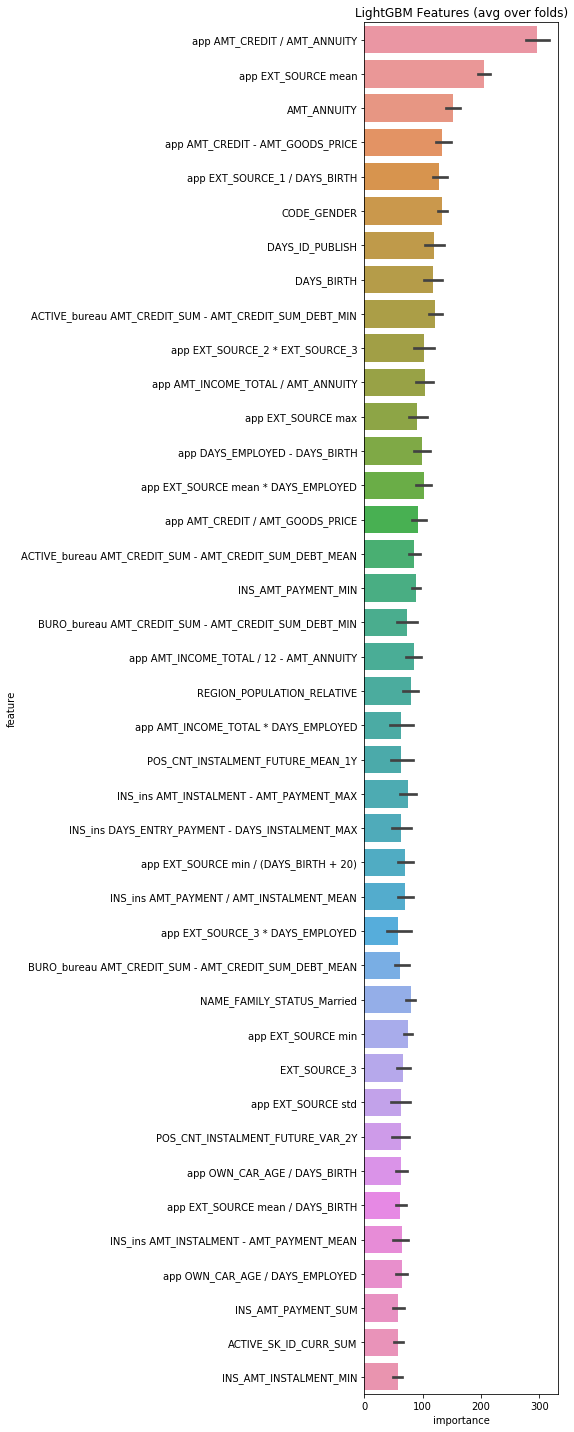

In [37]:
submission_file_name = "submission_0827_1.csv"
print("Run LightGBM with kfold")

feat_importance = kfold_lightgbm(df_train.head(100000), df_test.head(100000), num_folds=5, stratified= False, debug= True)
feat_importance.to_csv('feat_importance_0827.csv')


In [40]:
feat_importance.to_csv('feat_importance0828_00.csv')

In [38]:
len(feat_importance)

54870

In [124]:
#feat_importanceの小さいものは除去する
feat_list = feat_importance[2 <= feat_importance['importance']][['feature']].drop_duplicates()
feat_list = np.append(feat_list, 'TARGET')
feat_list = np.append(feat_list, 'SK_ID_CURR')
len(feat_list)

1554

In [126]:
items = list(feat_list)
items_add = []

for c in items:
    if 'ACTIVE_' in c:
        col_type = df_train[c].dtype
        if col_type != object:
            name = c + ' / DAYS_EMPLOYED'
            df_train[name] = df_train[c] / df_train['DAYS_EMPLOYED']
            df_test[name] = df_test[c] / df_test['DAYS_EMPLOYED']
            items_add.append(name)
for c in items:
    if 'CLOSED_' in c:
        col_type = df_train[c].dtype
        if col_type != object:
            name = c + ' / DAYS_EMPLOYED'
            df_train[name] = df_train[c] / df_train['DAYS_EMPLOYED']
            df_test[name] = df_test[c] / df_test['DAYS_EMPLOYED']
            items_add.append(name)


In [127]:
df_train['ACTIVE_MONTHS_BALANCE_SIZE_VAR / DAYS_EMPLOYED'].count()

42684

In [129]:
feat_list

array(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', ...,
       'CARD_card SK_DPD_DEF - MONTHS_BALANCE_MEAN', 'TARGET',
       'SK_ID_CURR'], dtype=object)

In [131]:
feat_list = list(feat_list) + items_add

In [132]:
len(feat_list)

1909

Run LightGBM with kfold
Starting LightGBM. Train shape: (307500, 1909), test shape: (48744, 1909)
len(feats): 1907
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.774482	valid_1's auc: 0.763498
[200]	training's auc: 0.796807	valid_1's auc: 0.779179
[300]	training's auc: 0.809781	valid_1's auc: 0.785434
[400]	training's auc: 0.819645	valid_1's auc: 0.788912
[500]	training's auc: 0.828363	valid_1's auc: 0.79102
[600]	training's auc: 0.835969	valid_1's auc: 0.792222
[700]	training's auc: 0.842701	valid_1's auc: 0.792996
[800]	training's auc: 0.848862	valid_1's auc: 0.793261
[900]	training's auc: 0.854721	valid_1's auc: 0.793586
[1000]	training's auc: 0.860275	valid_1's auc: 0.793724
[1100]	training's auc: 0.865752	valid_1's auc: 0.793758
[1200]	training's auc: 0.870953	valid_1's auc: 0.793727
Early stopping, best iteration is:
[1033]	training's auc: 0.862151	valid_1's auc: 0.7938
len(clf.feature_importances_): 1907
Fold  1 AUC : 0.793800
Training unt

C:\Users\tmiya\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


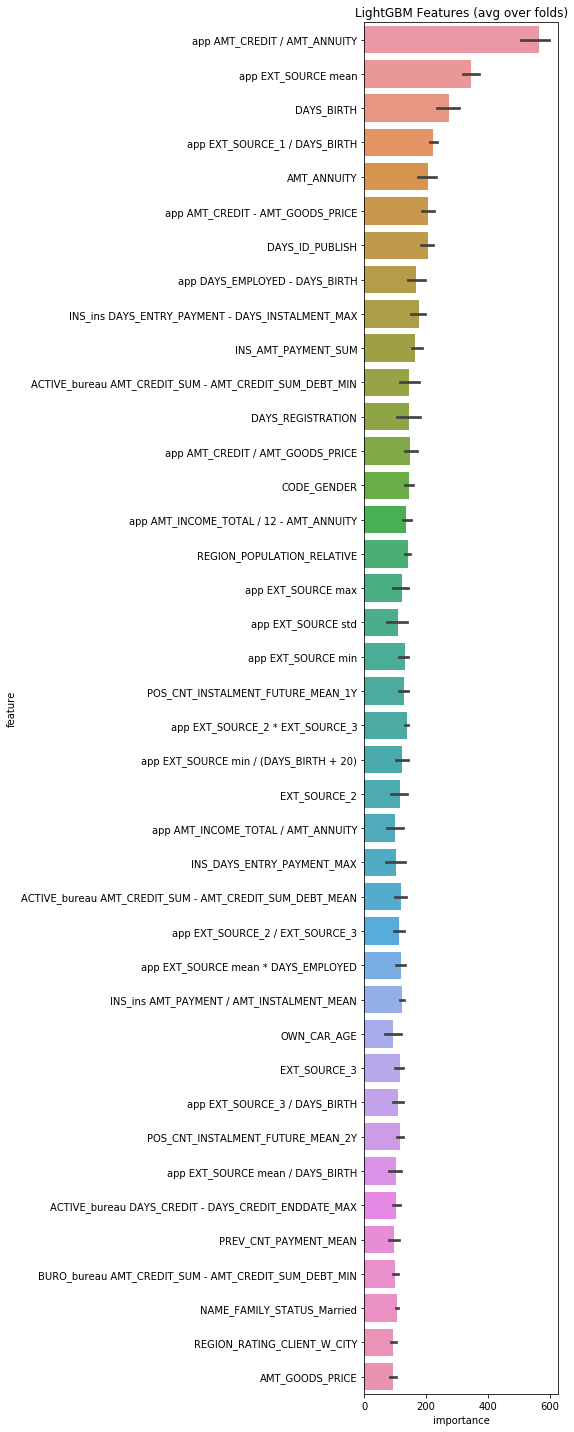

In [135]:
submission_file_name = "submission_0830_2.csv"
print("Run LightGBM with kfold")

#feat_list.to_csv('feat_list_0826.csv')

feat_importance_2 = kfold_lightgbm(df_train[feat_list], df_test[feat_list], num_folds=4, stratified= False, debug= False)

Run LightGBM with kfold
Starting LightGBM. Train shape: (307500, 1909), test shape: (48744, 1909)
len(feats): 1907
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.779657	valid_1's auc: 0.76451
[200]	training's auc: 0.802011	valid_1's auc: 0.778608
[300]	training's auc: 0.815684	valid_1's auc: 0.78425
[400]	training's auc: 0.826221	valid_1's auc: 0.787238
[500]	training's auc: 0.835215	valid_1's auc: 0.789166
[600]	training's auc: 0.842957	valid_1's auc: 0.790395
[700]	training's auc: 0.849921	valid_1's auc: 0.79091
[800]	training's auc: 0.856431	valid_1's auc: 0.791195
[900]	training's auc: 0.862282	valid_1's auc: 0.791484
[1000]	training's auc: 0.867972	valid_1's auc: 0.791619
[1100]	training's auc: 0.873191	valid_1's auc: 0.791652
[1200]	training's auc: 0.878085	valid_1's auc: 0.791817
[1300]	training's auc: 0.882712	valid_1's auc: 0.791893
[1400]	training's auc: 0.887342	valid_1's auc: 0.791912
[1500]	training's auc: 0.891459	valid_1's auc: 0.7

C:\Users\tmiya\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


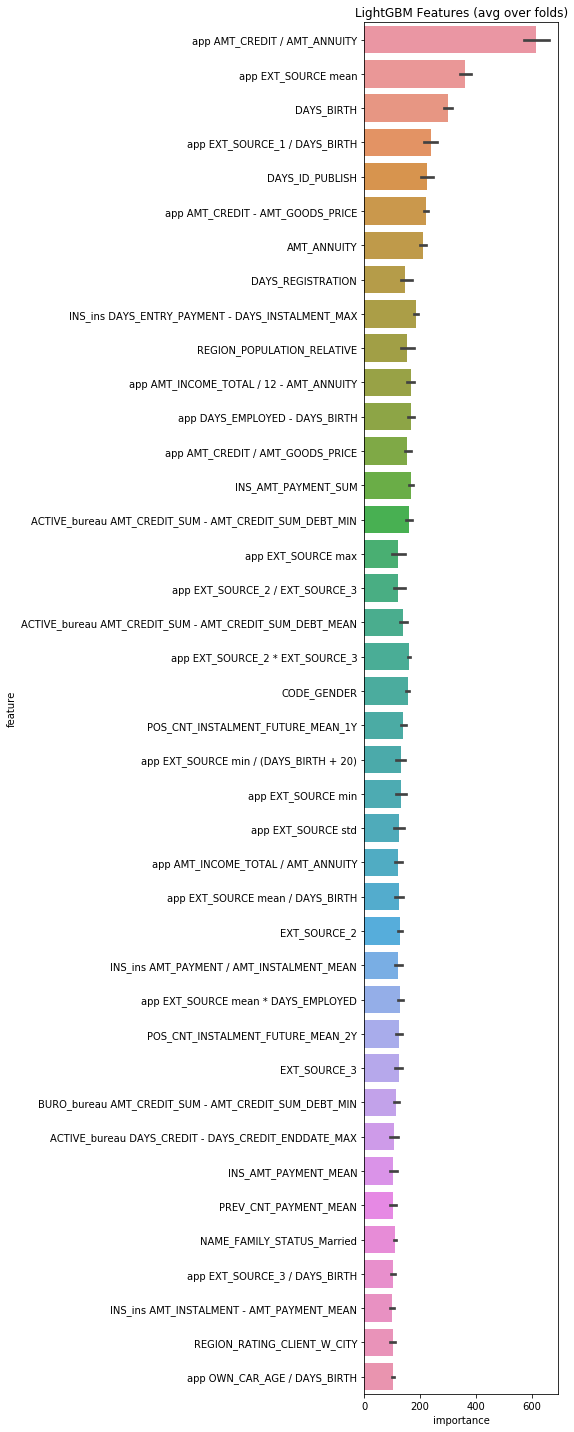

In [133]:
submission_file_name = "submission_0830.csv"
print("Run LightGBM with kfold")

#feat_list.to_csv('feat_list_0826.csv')

feat_importance_2 = kfold_lightgbm(df_train[feat_list], df_test[feat_list], num_folds=5, stratified= False, debug= False)

### featureでgroupbyして、最小値が0のものは除きたい

Run LightGBM with kfold
Starting LightGBM. Train shape: (307500, 1730), test shape: (48744, 1730)
len(feats): 1728
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.763732	valid_1's auc: 0.761995
[200]	training's auc: 0.779453	valid_1's auc: 0.774349
[300]	training's auc: 0.791977	valid_1's auc: 0.783069
[400]	training's auc: 0.801188	valid_1's auc: 0.787896
[500]	training's auc: 0.808475	valid_1's auc: 0.791092
[600]	training's auc: 0.814502	valid_1's auc: 0.793277
[700]	training's auc: 0.819939	valid_1's auc: 0.795285
[800]	training's auc: 0.824897	valid_1's auc: 0.79713
[900]	training's auc: 0.829381	valid_1's auc: 0.798467
[1000]	training's auc: 0.833603	valid_1's auc: 0.799269
[1100]	training's auc: 0.837523	valid_1's auc: 0.799871
[1200]	training's auc: 0.841116	valid_1's auc: 0.800267
[1300]	training's auc: 0.844494	valid_1's auc: 0.800728
[1400]	training's auc: 0.847775	valid_1's auc: 0.801072
[1500]	training's auc: 0.850992	valid_1's auc: 0

[2500]	training's auc: 0.878344	valid_1's auc: 0.806767
[2600]	training's auc: 0.880669	valid_1's auc: 0.806843
[2700]	training's auc: 0.882904	valid_1's auc: 0.807066
[2800]	training's auc: 0.885183	valid_1's auc: 0.807229
[2900]	training's auc: 0.887408	valid_1's auc: 0.807228
[3000]	training's auc: 0.889629	valid_1's auc: 0.807304
[3100]	training's auc: 0.891689	valid_1's auc: 0.807433
[3200]	training's auc: 0.893798	valid_1's auc: 0.807379
[3300]	training's auc: 0.895866	valid_1's auc: 0.807336
Early stopping, best iteration is:
[3128]	training's auc: 0.892259	valid_1's auc: 0.807459
len(clf.feature_importances_): 1728
Fold  5 AUC : 0.807459
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.764118	valid_1's auc: 0.750672
[200]	training's auc: 0.78042	valid_1's auc: 0.761823
[300]	training's auc: 0.792803	valid_1's auc: 0.769888
[400]	training's auc: 0.801919	valid_1's auc: 0.774822
[500]	training's auc: 0.809243	valid_1's auc: 0.778532
[600]	tra

[1800]	training's auc: 0.860801	valid_1's auc: 0.793059
[1900]	training's auc: 0.863622	valid_1's auc: 0.793321
[2000]	training's auc: 0.866418	valid_1's auc: 0.793528
[2100]	training's auc: 0.86904	valid_1's auc: 0.793628
[2200]	training's auc: 0.871639	valid_1's auc: 0.793666
[2300]	training's auc: 0.874118	valid_1's auc: 0.793607
Early stopping, best iteration is:
[2186]	training's auc: 0.871271	valid_1's auc: 0.793759
len(clf.feature_importances_): 1728
Fold 10 AUC : 0.793759
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.764806	valid_1's auc: 0.747141
[200]	training's auc: 0.780558	valid_1's auc: 0.757033
[300]	training's auc: 0.792848	valid_1's auc: 0.765665
[400]	training's auc: 0.801951	valid_1's auc: 0.771891
[500]	training's auc: 0.809146	valid_1's auc: 0.77598
[600]	training's auc: 0.81518	valid_1's auc: 0.778828
[700]	training's auc: 0.820611	valid_1's auc: 0.780891
[800]	training's auc: 0.825472	valid_1's auc: 0.782206
[900]	training

[2800]	training's auc: 0.884867	valid_1's auc: 0.797585
[2900]	training's auc: 0.886985	valid_1's auc: 0.7977
[3000]	training's auc: 0.889066	valid_1's auc: 0.797673
[3100]	training's auc: 0.891079	valid_1's auc: 0.797734
[3200]	training's auc: 0.893078	valid_1's auc: 0.797845
[3300]	training's auc: 0.895051	valid_1's auc: 0.797882
[3400]	training's auc: 0.896982	valid_1's auc: 0.798009
[3500]	training's auc: 0.898928	valid_1's auc: 0.798169
[3600]	training's auc: 0.900875	valid_1's auc: 0.798162
[3700]	training's auc: 0.902764	valid_1's auc: 0.798267
[3800]	training's auc: 0.904506	valid_1's auc: 0.798318
[3900]	training's auc: 0.906325	valid_1's auc: 0.798414
[4000]	training's auc: 0.907977	valid_1's auc: 0.798394
Early stopping, best iteration is:
[3855]	training's auc: 0.905573	valid_1's auc: 0.798447
len(clf.feature_importances_): 1728
Fold 14 AUC : 0.798447
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.76404	valid_1's auc: 0.755296
[200]	t

[200]	training's auc: 0.780035	valid_1's auc: 0.764479
[300]	training's auc: 0.792691	valid_1's auc: 0.77278
[400]	training's auc: 0.801816	valid_1's auc: 0.778556
[500]	training's auc: 0.808986	valid_1's auc: 0.782493
[600]	training's auc: 0.815047	valid_1's auc: 0.78545
[700]	training's auc: 0.820293	valid_1's auc: 0.787656
[800]	training's auc: 0.82518	valid_1's auc: 0.789299
[900]	training's auc: 0.829787	valid_1's auc: 0.790501
[1000]	training's auc: 0.834023	valid_1's auc: 0.791508
[1100]	training's auc: 0.837996	valid_1's auc: 0.792244
[1200]	training's auc: 0.841618	valid_1's auc: 0.792635
[1300]	training's auc: 0.845014	valid_1's auc: 0.793003
[1400]	training's auc: 0.848275	valid_1's auc: 0.793195
[1500]	training's auc: 0.85149	valid_1's auc: 0.793466
[1600]	training's auc: 0.854578	valid_1's auc: 0.793739
[1700]	training's auc: 0.857515	valid_1's auc: 0.793756
[1800]	training's auc: 0.860403	valid_1's auc: 0.793965
[1900]	training's auc: 0.863028	valid_1's auc: 0.794154
[200

C:\Users\tmiya\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


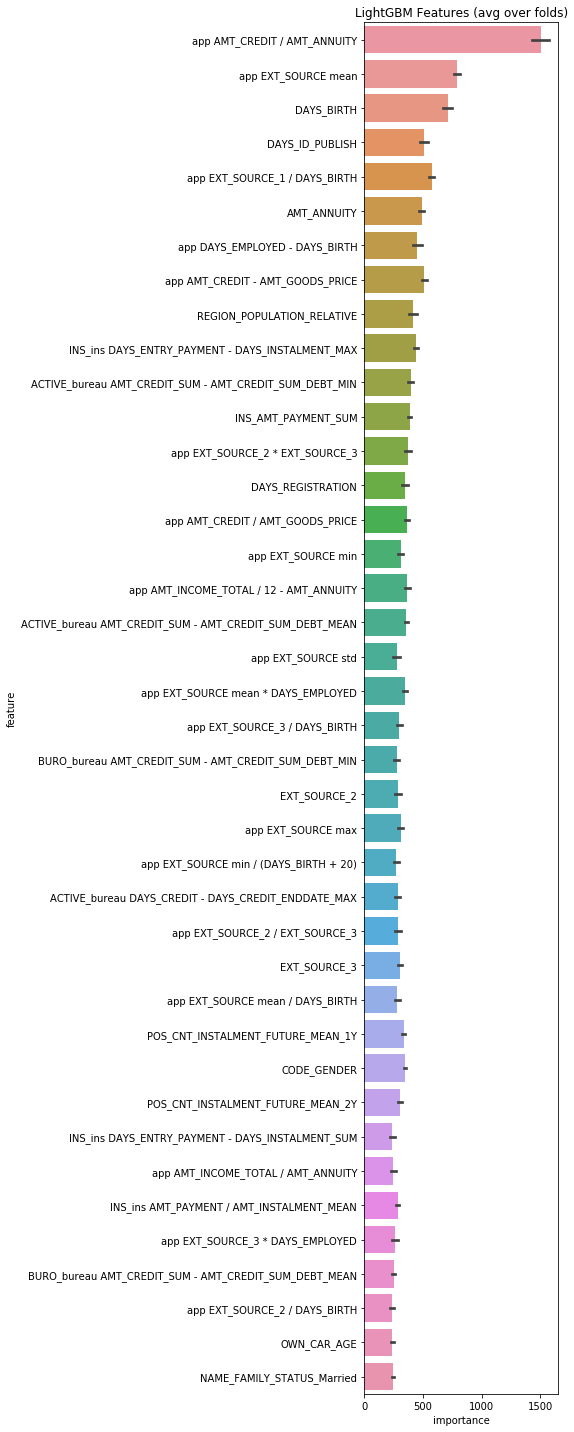

In [110]:
submission_file_name = "submission_0829_3.csv"
print("Run LightGBM with kfold")

#feat_list.to_csv('feat_list_0826.csv')

feat_importance_2 = kfold_lightgbm(df_train[feat_list], df_test[feat_list], num_folds=20, stratified= False, debug= False)

Run LightGBM with kfold
Starting LightGBM. Train shape: (307500, 1730), test shape: (48744, 1730)
len(feats): 1728
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.76377	valid_1's auc: 0.759478
[200]	training's auc: 0.77961	valid_1's auc: 0.772122
[300]	training's auc: 0.792011	valid_1's auc: 0.780311
[400]	training's auc: 0.801115	valid_1's auc: 0.785077
[500]	training's auc: 0.808424	valid_1's auc: 0.787984
[600]	training's auc: 0.814408	valid_1's auc: 0.790145
[700]	training's auc: 0.819729	valid_1's auc: 0.792034
[800]	training's auc: 0.824533	valid_1's auc: 0.793523
[900]	training's auc: 0.82898	valid_1's auc: 0.794568
[1000]	training's auc: 0.833116	valid_1's auc: 0.795491
[1100]	training's auc: 0.837039	valid_1's auc: 0.796099
[1200]	training's auc: 0.840702	valid_1's auc: 0.796465
[1300]	training's auc: 0.844217	valid_1's auc: 0.796731
[1400]	training's auc: 0.847515	valid_1's auc: 0.797027
[1500]	training's auc: 0.850672	valid_1's auc: 0.7

[300]	training's auc: 0.79203	valid_1's auc: 0.780072
[400]	training's auc: 0.801189	valid_1's auc: 0.785387
[500]	training's auc: 0.808435	valid_1's auc: 0.789121
[600]	training's auc: 0.814445	valid_1's auc: 0.791796
[700]	training's auc: 0.81973	valid_1's auc: 0.793411
[800]	training's auc: 0.824529	valid_1's auc: 0.79481
[900]	training's auc: 0.829015	valid_1's auc: 0.795845
[1000]	training's auc: 0.833149	valid_1's auc: 0.796794
[1100]	training's auc: 0.837026	valid_1's auc: 0.797777
[1200]	training's auc: 0.840657	valid_1's auc: 0.798079
[1300]	training's auc: 0.844273	valid_1's auc: 0.798504
[1400]	training's auc: 0.847548	valid_1's auc: 0.798891
[1500]	training's auc: 0.850751	valid_1's auc: 0.799099
[1600]	training's auc: 0.853816	valid_1's auc: 0.799422
[1700]	training's auc: 0.856799	valid_1's auc: 0.799386
[1800]	training's auc: 0.859665	valid_1's auc: 0.799422
[1900]	training's auc: 0.862391	valid_1's auc: 0.799458
[2000]	training's auc: 0.865071	valid_1's auc: 0.799527
[2

[600]	training's auc: 0.814246	valid_1's auc: 0.790026
[700]	training's auc: 0.819526	valid_1's auc: 0.791972
[800]	training's auc: 0.824383	valid_1's auc: 0.793712
[900]	training's auc: 0.828913	valid_1's auc: 0.794945
[1000]	training's auc: 0.833083	valid_1's auc: 0.795717
[1100]	training's auc: 0.836829	valid_1's auc: 0.796285
[1200]	training's auc: 0.840438	valid_1's auc: 0.79681
[1300]	training's auc: 0.843874	valid_1's auc: 0.797456
[1400]	training's auc: 0.847238	valid_1's auc: 0.79784
[1500]	training's auc: 0.850413	valid_1's auc: 0.798216
[1600]	training's auc: 0.853411	valid_1's auc: 0.798737
[1700]	training's auc: 0.856389	valid_1's auc: 0.79907
[1800]	training's auc: 0.859201	valid_1's auc: 0.799318
[1900]	training's auc: 0.861966	valid_1's auc: 0.799553
[2000]	training's auc: 0.864511	valid_1's auc: 0.799699
[2100]	training's auc: 0.867064	valid_1's auc: 0.799761
[2200]	training's auc: 0.869547	valid_1's auc: 0.800007
[2300]	training's auc: 0.872094	valid_1's auc: 0.800091

Early stopping, best iteration is:
[1880]	training's auc: 0.862207	valid_1's auc: 0.793736
len(clf.feature_importances_): 1728
Fold 15 AUC : 0.793736
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.764783	valid_1's auc: 0.738466
[200]	training's auc: 0.780388	valid_1's auc: 0.748548
[300]	training's auc: 0.792743	valid_1's auc: 0.758285
[400]	training's auc: 0.801734	valid_1's auc: 0.765084
[500]	training's auc: 0.808874	valid_1's auc: 0.76975
[600]	training's auc: 0.814743	valid_1's auc: 0.772985
[700]	training's auc: 0.820001	valid_1's auc: 0.775355
[800]	training's auc: 0.82483	valid_1's auc: 0.777077
[900]	training's auc: 0.829339	valid_1's auc: 0.778371
[1000]	training's auc: 0.8336	valid_1's auc: 0.779552
[1100]	training's auc: 0.837472	valid_1's auc: 0.78081
[1200]	training's auc: 0.841064	valid_1's auc: 0.781526
[1300]	training's auc: 0.844535	valid_1's auc: 0.782286
[1400]	training's auc: 0.847774	valid_1's auc: 0.782624
[1500]	training's

[3500]	training's auc: 0.898879	valid_1's auc: 0.791507
[3600]	training's auc: 0.900788	valid_1's auc: 0.79162
[3700]	training's auc: 0.902678	valid_1's auc: 0.791627
[3800]	training's auc: 0.904478	valid_1's auc: 0.791753
[3900]	training's auc: 0.906298	valid_1's auc: 0.791798
[4000]	training's auc: 0.90803	valid_1's auc: 0.791863
[4100]	training's auc: 0.909717	valid_1's auc: 0.792002
[4200]	training's auc: 0.91144	valid_1's auc: 0.792085
[4300]	training's auc: 0.913129	valid_1's auc: 0.792246
[4400]	training's auc: 0.914835	valid_1's auc: 0.792301
[4500]	training's auc: 0.916401	valid_1's auc: 0.792364
[4600]	training's auc: 0.917988	valid_1's auc: 0.792347
[4700]	training's auc: 0.919583	valid_1's auc: 0.792163
[4800]	training's auc: 0.92119	valid_1's auc: 0.792209
Early stopping, best iteration is:
[4628]	training's auc: 0.918431	valid_1's auc: 0.792401
len(clf.feature_importances_): 1728
Fold 19 AUC : 0.792401
Training until validation scores don't improve for 200 rounds.
[100]	t

[400]	training's auc: 0.801133	valid_1's auc: 0.784878
[500]	training's auc: 0.808219	valid_1's auc: 0.788869
[600]	training's auc: 0.814266	valid_1's auc: 0.791908
[700]	training's auc: 0.819581	valid_1's auc: 0.794121
[800]	training's auc: 0.824477	valid_1's auc: 0.79547
[900]	training's auc: 0.829016	valid_1's auc: 0.796888
[1000]	training's auc: 0.833166	valid_1's auc: 0.797968
[1100]	training's auc: 0.836945	valid_1's auc: 0.799127
[1200]	training's auc: 0.840646	valid_1's auc: 0.79996
[1300]	training's auc: 0.84408	valid_1's auc: 0.800608
[1400]	training's auc: 0.847469	valid_1's auc: 0.801196
[1500]	training's auc: 0.850589	valid_1's auc: 0.801523
[1600]	training's auc: 0.853689	valid_1's auc: 0.801813
[1700]	training's auc: 0.856597	valid_1's auc: 0.802237
[1800]	training's auc: 0.85933	valid_1's auc: 0.802661
[1900]	training's auc: 0.862076	valid_1's auc: 0.802679
[2000]	training's auc: 0.864814	valid_1's auc: 0.802888
[2100]	training's auc: 0.867411	valid_1's auc: 0.803067
[2

[1700]	training's auc: 0.856554	valid_1's auc: 0.791679
[1800]	training's auc: 0.859314	valid_1's auc: 0.791809
[1900]	training's auc: 0.862066	valid_1's auc: 0.791922
[2000]	training's auc: 0.864663	valid_1's auc: 0.792173
[2100]	training's auc: 0.867298	valid_1's auc: 0.792307
[2200]	training's auc: 0.869895	valid_1's auc: 0.792503
[2300]	training's auc: 0.872318	valid_1's auc: 0.792472
[2400]	training's auc: 0.874699	valid_1's auc: 0.792574
[2500]	training's auc: 0.877063	valid_1's auc: 0.792672
[2600]	training's auc: 0.879411	valid_1's auc: 0.792863
[2700]	training's auc: 0.881815	valid_1's auc: 0.79296
[2800]	training's auc: 0.88411	valid_1's auc: 0.792978
[2900]	training's auc: 0.886249	valid_1's auc: 0.793056
[3000]	training's auc: 0.888392	valid_1's auc: 0.793072
[3100]	training's auc: 0.890516	valid_1's auc: 0.793093
Early stopping, best iteration is:
[2988]	training's auc: 0.888128	valid_1's auc: 0.793167
len(clf.feature_importances_): 1728
Fold 28 AUC : 0.793167
Training unt

C:\Users\tmiya\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


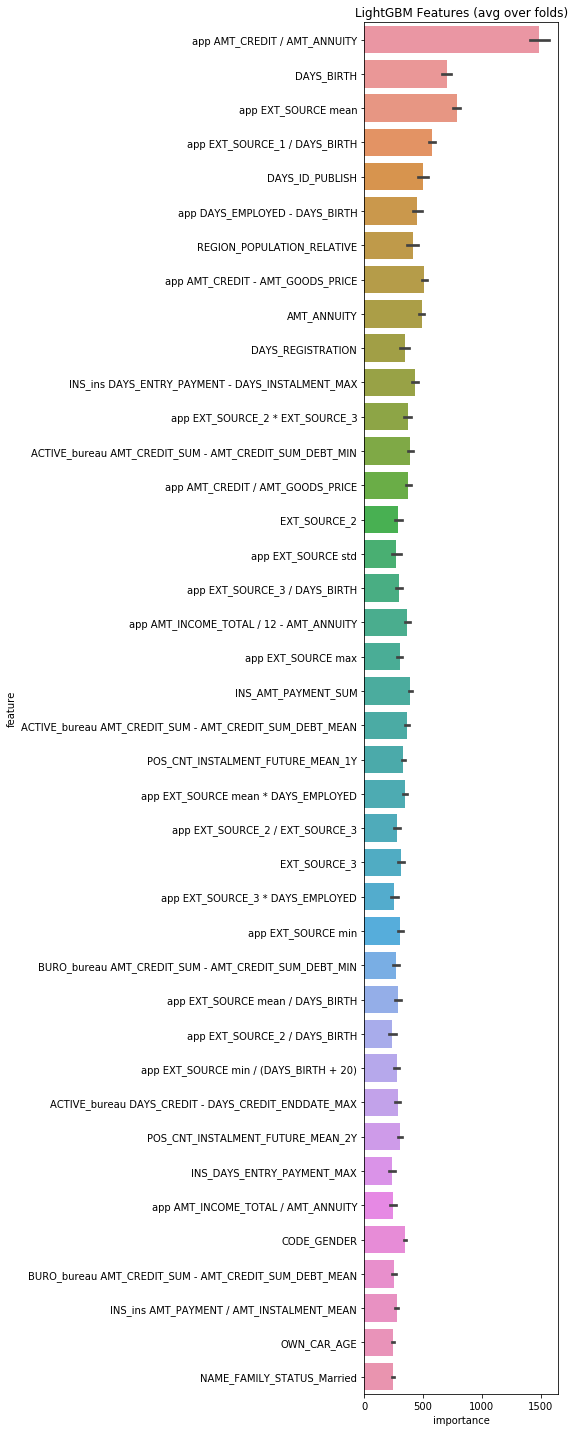

In [111]:
submission_file_name = "submission_0829_4.csv"
print("Run LightGBM with kfold")

#feat_list.to_csv('feat_list_0826.csv')

feat_importance_3 = kfold_lightgbm(df_train[feat_list], df_test[feat_list], num_folds=30, stratified= False, debug= False)

In [112]:
feat_importance_3.to_csv('feat_importance_3_0829.csv')

In [137]:
len(df['AMT_GOODS_PRICE'])

356244